In [2]:
#determine the vegetation type for each pixel
#add in overall landcover type based on 5 nearest neighbours

#Manual entries
CITY_COUNTRY = "HUAMBO_ANGOLA"

SATELLITE = 'MOD11A2' #TERRA
#SATELLITE = 'MYD11A2' #AQUA

In [3]:
#Import packages
import os
import re  # regular expressions for getting lat lon grid
import pathlib
import warnings
import gdal
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import rasterio as rio # for extracting subsets
from rasterio.plot import plotting_extent #for plotting
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import earthpy.mask as em
import pandas as pd
import pickle
import matplotlib.patches as mpatches

#for the reprojecting
import pyproj
from pyproj import CRS
from pyproj import Transformer
import cartopy
import cartopy.crs as ccrs
from shapely.geometry import Point, LineString, Polygon
from pyhdf.SD import SD, SDC
import datetime as dt
import scipy
from scipy import interpolate
import geopandas as gpd
#for converting to different projections (to local epsg)
from pyproj import Transformer

#for finding the mode
from collections import Counter

#import affine 2D for the transformations (to offset error bars)
from matplotlib.transforms import Affine2D

#for reading the elevation dataset
import xarray as xr
#for finding nearest points (to add on elevation information)
from scipy import spatial
# for scatter contour plots
import seaborn as sns 
#load in csv of city lons and lats
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))

CITY_COUNTRY_lat_lon = pd.read_excel('CITY_COUNTRY_lat_lon.xlsx')
#drop the rows for the cities not looking at, reset index after dropping, drop old index
#CITY_COUNTRY_lat_lon = CITY_COUNTRY_lat_lon.drop([9,11,18,22,23]).reset_index(drop = True)

#Identify names/ values of chosen city
#set the city latitude and longitudes and city name
City_Lat = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['Lat'].values[0]
City_Lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['Lon'].values[0]
City_name = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City'].values[0]
City_area = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City_Area'].values[0]
City_bound_xmin = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City_Bound_xmin'].values[0]/1000
City_bound_xmax = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City_Bound_xmax'].values[0]/1000
City_bound_ymin = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City_Bound_ymin'].values[0]/1000
City_bound_ymax = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City_Bound_ymax'].values[0]/1000
#city extent bound used as constraint. Used 2*sqrt(city_area) +2
City_extent_bound = 2*np.sqrt(City_area) + 2


#Area to look at will be the city centre +/- 0.2 degs
min_lat = City_Lat - 0.2
max_lat = City_Lat + 0.2
min_lon = City_Lon - 0.2
max_lon = City_Lon + 0.2


#create satellite name for plots
if SATELLITE == 'MOD11A2':
    satellite_name = 'Terra'
else:
    satellite_name = 'Aqua'
    
#Load in LULC data, these bases were created in JASMIN
with open('UHI_Project_Pickle_Files\LULC_Pickles\LULC_{}.pkl'.format(CITY_COUNTRY), 'rb') as f:
     LULC_df = pickle.load(f)

C:\Anaconda3\envs\project_environment\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [169]:
#determine the class for each pixel in the specified year
#5

lccs_class_overall_2000_list = []

for a in range(len(LULC_df)):
    #get list of pixel classifications
    row = LULC_df.iloc[a]
    pixel_list = []

    for i in [1,2,3,4,5]: #the numbers for the 5 pixels
        pixel_name = 'lccs_class_{}_2000'.format(i)
        x = row[pixel_name]
        pixel_list.append(x)
    #find the mode of the list
    counter = Counter(pixel_list)
    max_count = max(counter.values())
    mode = [k for k,v in counter.items() if v == max_count]    #use the most common pixel classification. 
                                                                #if are equal numbers, the one assigned to nearer pixel is used
    lccs_class_overall_2000_list.append(mode[0])

#lccs_class_overall_2005
lccs_class_overall_2005_list = []

for a in range(len(LULC_df)):
    #get list of pixel classifications
    row = LULC_df.iloc[a]
    pixel_list = []

    for i in [1,2,3,4,5]: #the numbers for the 5 pixels
        pixel_name = 'lccs_class_{}_2005'.format(i)
        x = row[pixel_name]
        pixel_list.append(x)
    #find the mode of the list
    counter = Counter(pixel_list)
    max_count = max(counter.values())
    mode = [k for k,v in counter.items() if v == max_count]    #use the most common pixel classification. 
                                                                #if are equal numbers, the one assigned to nearer pixel is used
    lccs_class_overall_2005_list.append(mode[0])

#lccs_class_overall_2010
lccs_class_overall_2010_list = []

for a in range(len(LULC_df)):
    #get list of pixel classifications
    row = LULC_df.iloc[a]
    pixel_list = []

    for i in [1,2,3,4,5]: #the numbers for the 5 pixels
        pixel_name = 'lccs_class_{}_2010'.format(i)
        x = row[pixel_name]
        pixel_list.append(x)
    #find the mode of the list
    counter = Counter(pixel_list)
    max_count = max(counter.values())
    mode = [k for k,v in counter.items() if v == max_count]    #use the most common pixel classification. 
                                                                #if are equal numbers, the one assigned to nearer pixel is used
    lccs_class_overall_2010_list.append(mode[0])

#lccs_class_overall_2015
lccs_class_overall_2015_list = []

for a in range(len(LULC_df)):
    #get list of pixel classifications
    row = LULC_df.iloc[a]
    pixel_list = []

    for i in [1,2,3,4,5]: #the numbers for the 5 pixels
        pixel_name = 'lccs_class_{}_2015'.format(i)
        x = row[pixel_name]
        pixel_list.append(x)
    #find the mode of the list
    counter = Counter(pixel_list)
    max_count = max(counter.values())
    mode = [k for k,v in counter.items() if v == max_count]    #use the most common pixel classification. 
                                                                #if are equal numbers, the one assigned to nearer pixel is used
    lccs_class_overall_2015_list.append(mode[0])
    
    
#add the classifications back into the LULC_df
LULC_df['lccs_class_overall_2000'] = lccs_class_overall_2000_list
LULC_df['lccs_class_overall_2005'] = lccs_class_overall_2005_list
LULC_df['lccs_class_overall_2010'] = lccs_class_overall_2010_list
LULC_df['lccs_class_overall_2015'] = lccs_class_overall_2015_list

#save the new LULC_df so the new rows are in it
#save the new df as a pickle
#pickle_name = 'Parameters_Day_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
with open('UHI_Project_Pickle_Files\LULC_Pickles\LULC_{}.pkl'.format(CITY_COUNTRY), 'wb') as f:
    pickle.dump(LULC_df, f)

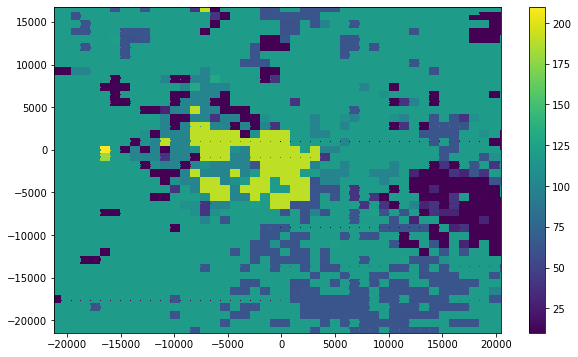

In [170]:
#Day
fig = plt.figure(figsize=(10, 6))
ax=plt.gca()

x = LULC_df.x_points
y = LULC_df.y_points
LULC_class = LULC_df.lccs_class_overall_2000

#get the points into the correct format
X ,Y = np.meshgrid(x ,y)
Z = scipy.interpolate.griddata((x, y), LULC_class, (X,Y), method='nearest')

c = ax.pcolormesh(X,Y, Z, shading = 'auto')
fig.colorbar(c, ax=ax)


In [171]:
#add the key into the dataframe
#key
value = [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220]
label = ['No Data', 'Cropland, rainfed','Cropland, irrigated or post-flooding', 
         'Mosaic cropland (>50%) / natural vegetation (tree, shrub, herbaceous cover)(<50%)'
         ,'Mosaic natural vegetation (tree, shrub, herbaceous cover) (>50%) / cropland(<50%)'
         ,'Tree cover, broadleaved, evergreen, closed to open (>15%)'
         ,'Tree cover, broadleaved, deciduous, closed to open (>15%)'
         ,'Tree cover, needleleaved, evergreen, closed to open (>15%)'
         ,'Tree cover, needleleaved, deciduous, closed to open (>15%)'
         ,'Tree cover, mixed leaf type (broadleaved and needleleaved)'
         ,'Mosaic tree and shrub (>50%) / herbaceous cover (<50%)'
         ,'Mosaic herbaceous cover (>50%) / tree and shrub (<50%)','Shrubland','Grassland','Lichens and mosses',
         'Sparse vegetation (tree, shrub, herbaceous cover) (<15%)'
         ,'Tree cover, flooded, fresh or brakish water'
         ,'Tree cover, flooded, saline water'
         ,'Shrub or herbaceous cover, flooded, fresh/saline/brakish water'
         ,'Urban areas','Bare areas','Water bodies','Permanent snow and ice']

label_color = ['black','yellow','cyan','khaki','darkkhaki','forestgreen','limegreen','darkgreen','olive','darkgoldenrod',
             'goldenrod','sienna','saddlebrown','darkorange','pink','bisque','turquoise','lightseagreen',
              'springgreen','red','beige','blue','white']

d= {'Value':value, 'Label':label, 'Label_color':label_color}
LULC_key = pd.DataFrame(data = d )

lccs_class_2000_label_list = []

for i in range(len(LULC_df)):
    row = LULC_df.iloc[i]
    for x in range(len(LULC_key)):
        if LULC_key.iloc[x].Value == row['lccs_class_overall_2000']:
            lab = LULC_key.iloc[x].Label
            
    lccs_class_2000_label_list.append(lab)


LULC_df['lccs_class_2000_label'] = lccs_class_2000_label_list


#add a second key to the dataframe, with categories merged
label2 = ['No Data', 'Cropland, rainfed','Cropland, irrigated or post-flooding', 
         'Mosaic cropland / natural vegetation (tree, shrub, herbaceous cover)'
         ,'Mosaic cropland / natural vegetation (tree, shrub, herbaceous cover)'
         ,'Tree cover'
         ,'Tree cover'
         ,'Tree cover'
         ,'Tree cover'
         ,'Tree cover'
         ,'Mosaic tree and shrub / herbaceous cover'
         ,'Mosaic tree and shrub / herbaceous cover','Shrubland','Grassland','Lichens and mosses',
         'Sparse vegetation (tree, shrub, herbaceous cover) (<15%)'
         ,'Tree cover, flooded'
         ,'Tree cover, flooded'
         ,'Shrub or herbaceous cover, flooded'
         ,'Urban areas','Bare areas','Water bodies','Permanent snow and ice']

label_color2 = ['black','yellow','cyan','darkkhaki','darkkhaki','forestgreen','forestgreen','forestgreen','forestgreen','forestgreen',
             'goldenrod','goldenrod','saddlebrown','darkorange','pink','bisque','turquoise','turquoise',
              'springgreen','red','beige','blue','white']

d= {'Value':value, 'Label2':label2, 'Label_color2':label_color2}
LULC_key2 = pd.DataFrame(data = d )

#2000
lccs_class_2000_label_list = []

for i in range(len(LULC_df)):
    row = LULC_df.iloc[i]
    for x in range(len(LULC_key2)):
        if LULC_key2.iloc[x].Value == row['lccs_class_overall_2000']:
            lab = LULC_key2.iloc[x].Label2
            
    lccs_class_2000_label_list.append(lab)

#2005    
lccs_class_2005_label_list = []

for i in range(len(LULC_df)):
    row = LULC_df.iloc[i]
    for x in range(len(LULC_key2)):
        if LULC_key2.iloc[x].Value == row['lccs_class_overall_2005']:
            lab = LULC_key2.iloc[x].Label2
            
    lccs_class_2005_label_list.append(lab)
#2010    
lccs_class_2010_label_list = []

for i in range(len(LULC_df)):
    row = LULC_df.iloc[i]
    for x in range(len(LULC_key2)):
        if LULC_key2.iloc[x].Value == row['lccs_class_overall_2010']:
            lab = LULC_key2.iloc[x].Label2
            
    lccs_class_2010_label_list.append(lab)
#2015    
lccs_class_2015_label_list = []

for i in range(len(LULC_df)):
    row = LULC_df.iloc[i]
    for x in range(len(LULC_key2)):
        if LULC_key2.iloc[x].Value == row['lccs_class_overall_2015']:
            lab = LULC_key2.iloc[x].Label2
            
    lccs_class_2015_label_list.append(lab)
    
LULC_df['lccs_class_2000_label2'] = lccs_class_2000_label_list
LULC_df['lccs_class_2005_label2'] = lccs_class_2005_label_list
LULC_df['lccs_class_2010_label2'] = lccs_class_2010_label_list
LULC_df['lccs_class_2015_label2'] = lccs_class_2015_label_list

In [172]:
#create a dataframe to be filled
LULC_percentages = LULC_key.copy()
LULC_percentages['Percent_2000'] = 0
LULC_percentages['Percent_2005'] = 0
LULC_percentages['Percent_2010'] = 0
LULC_percentages['Percent_2015'] = 0

total = LULC_df.count()[0] # total number of pixels

#take global definitions, so if regional (ie 11, 12, etc), round down
LULC_df['lccs_class_overall_2000'] = LULC_df['lccs_class_overall_2000'].round(-1)
LULC_df['lccs_class_overall_2005'] = LULC_df['lccs_class_overall_2005'].round(-1)
LULC_df['lccs_class_overall_2010'] = LULC_df['lccs_class_overall_2010'].round(-1)
LULC_df['lccs_class_overall_2015'] = LULC_df['lccs_class_overall_2015'].round(-1)

#work out the percentages for 2000
lccs_count_2000 = pd.DataFrame(data = 100* LULC_df.groupby(['lccs_class_overall_2000']).Latitude.count()/total )
lccs_count_2000.columns = ['percent'] 
lccs_count_2000['Value'] = lccs_count_2000.index

#add to the percentages dataframe
for i in range(len(lccs_count_2000)):
    value = lccs_count_2000.iloc[i].Value
    percent = lccs_count_2000.iloc[i].percent
    LULC_percentages.loc[LULC_percentages['Value'] == value, 'Percent_2000'] = percent
    
#work out the percentages for 2005
lccs_count_2005 = pd.DataFrame(data = 100* LULC_df.groupby(['lccs_class_overall_2005']).Latitude.count()/total )
lccs_count_2005.columns = ['percent'] 
lccs_count_2005['Value'] = lccs_count_2005.index

#add to the percentages dataframe
for i in range(len(lccs_count_2005)):
    value = lccs_count_2005.iloc[i].Value
    percent = lccs_count_2005.iloc[i].percent
    LULC_percentages.loc[LULC_percentages['Value'] == value, 'Percent_2005'] = percent
    
#work out the percentages for 2010
lccs_count_2010 = pd.DataFrame(data = 100* LULC_df.groupby(['lccs_class_overall_2010']).Latitude.count()/total )
lccs_count_2010.columns = ['percent'] 
lccs_count_2010['Value'] = lccs_count_2010.index

#add to the percentages dataframe
for i in range(len(lccs_count_2010)):
    value = lccs_count_2010.iloc[i].Value
    percent = lccs_count_2010.iloc[i].percent
    LULC_percentages.loc[LULC_percentages['Value'] == value, 'Percent_2010'] = percent
    
#work out the percentages for 2015
lccs_count_2015 = pd.DataFrame(data = 100* LULC_df.groupby(['lccs_class_overall_2015']).Latitude.count()/total )
lccs_count_2015.columns = ['percent'] 
lccs_count_2015['Value'] = lccs_count_2015.index

#add to the percentages dataframe
for i in range(len(lccs_count_2015)):
    value = lccs_count_2015.iloc[i].Value
    percent = lccs_count_2015.iloc[i].percent
    LULC_percentages.loc[LULC_percentages['Value'] == value, 'Percent_2015'] = percent

In [173]:
#Label2 - create a dataframe with the less detailed description/ merged

#create a dataframe to be filled
LULC_percentages2 = LULC_key2.drop(columns=['Value']).drop_duplicates().copy()
LULC_percentages2['Percent_2000'] = 0
LULC_percentages2['Percent_2005'] = 0
LULC_percentages2['Percent_2010'] = 0
LULC_percentages2['Percent_2015'] = 0

total = LULC_df.count()[0] # total number of pixels

#work out the percentages for 2000
lccs_count_2000 = pd.DataFrame(data = 100* LULC_df.groupby(['lccs_class_2000_label2']).Latitude.count()/total )
lccs_count_2000.columns = ['percent']
lccs_count_2000['Label2'] = lccs_count_2000.index

#add to the percentages dataframe
for i in range(len(lccs_count_2000)):
    label = lccs_count_2000.iloc[i].Label2
    percent = lccs_count_2000.iloc[i].percent
    LULC_percentages2.loc[LULC_percentages2['Label2'] == label, 'Percent_2000'] = percent
    
#work out the percentages for 2005
lccs_count_2005 = pd.DataFrame(data = 100* LULC_df.groupby(['lccs_class_2005_label2']).Latitude.count()/total )
lccs_count_2005.columns = ['percent']
lccs_count_2005['Label2'] = lccs_count_2005.index

#add to the percentages dataframe
for i in range(len(lccs_count_2005)):
    label = lccs_count_2005.iloc[i].Label2
    percent = lccs_count_2005.iloc[i].percent
    LULC_percentages2.loc[LULC_percentages2['Label2'] == label, 'Percent_2005'] = percent

#work out the percentages for 2010
lccs_count_2010 = pd.DataFrame(data = 100* LULC_df.groupby(['lccs_class_2010_label2']).Latitude.count()/total )
lccs_count_2010.columns = ['percent']
lccs_count_2010['Label2'] = lccs_count_2010.index

#add to the percentages dataframe
for i in range(len(lccs_count_2010)):
    label = lccs_count_2010.iloc[i].Label2
    percent = lccs_count_2010.iloc[i].percent
    LULC_percentages2.loc[LULC_percentages2['Label2'] == label, 'Percent_2010'] = percent

#work out the percentages for 2015
lccs_count_2015 = pd.DataFrame(data = 100* LULC_df.groupby(['lccs_class_2015_label2']).Latitude.count()/total )
lccs_count_2015.columns = ['percent']
lccs_count_2015['Label2'] = lccs_count_2015.index

#add to the percentages dataframe
for i in range(len(lccs_count_2015)):
    label = lccs_count_2015.iloc[i].Label2
    percent = lccs_count_2015.iloc[i].percent
    LULC_percentages2.loc[LULC_percentages2['Label2'] == label, 'Percent_2015'] = percent


In [12]:
per_2015 = LULC_percentages[(LULC_percentages['Percent_2015'] != 0)].Percent_2015
labels = LULC_percentages[(LULC_percentages['Percent_2015'] != 0)].Label
label_color = LULC_percentages[(LULC_percentages['Percent_2015'] != 0)].Label_color

C:\Anaconda3\envs\project_environment\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  """Entry point for launching an IPython kernel.


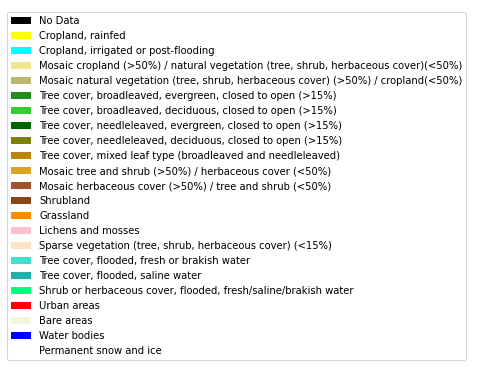

In [13]:
plt.pie(np.zeros(len(LULC_percentages)), labels = LULC_percentages.Label, labeldistance = None, colors = LULC_percentages.Label_color)
plt.legend()

C:\Anaconda3\envs\project_environment\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
C:\Anaconda3\envs\project_environment\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
C:\Anaconda3\envs\project_environment\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making 

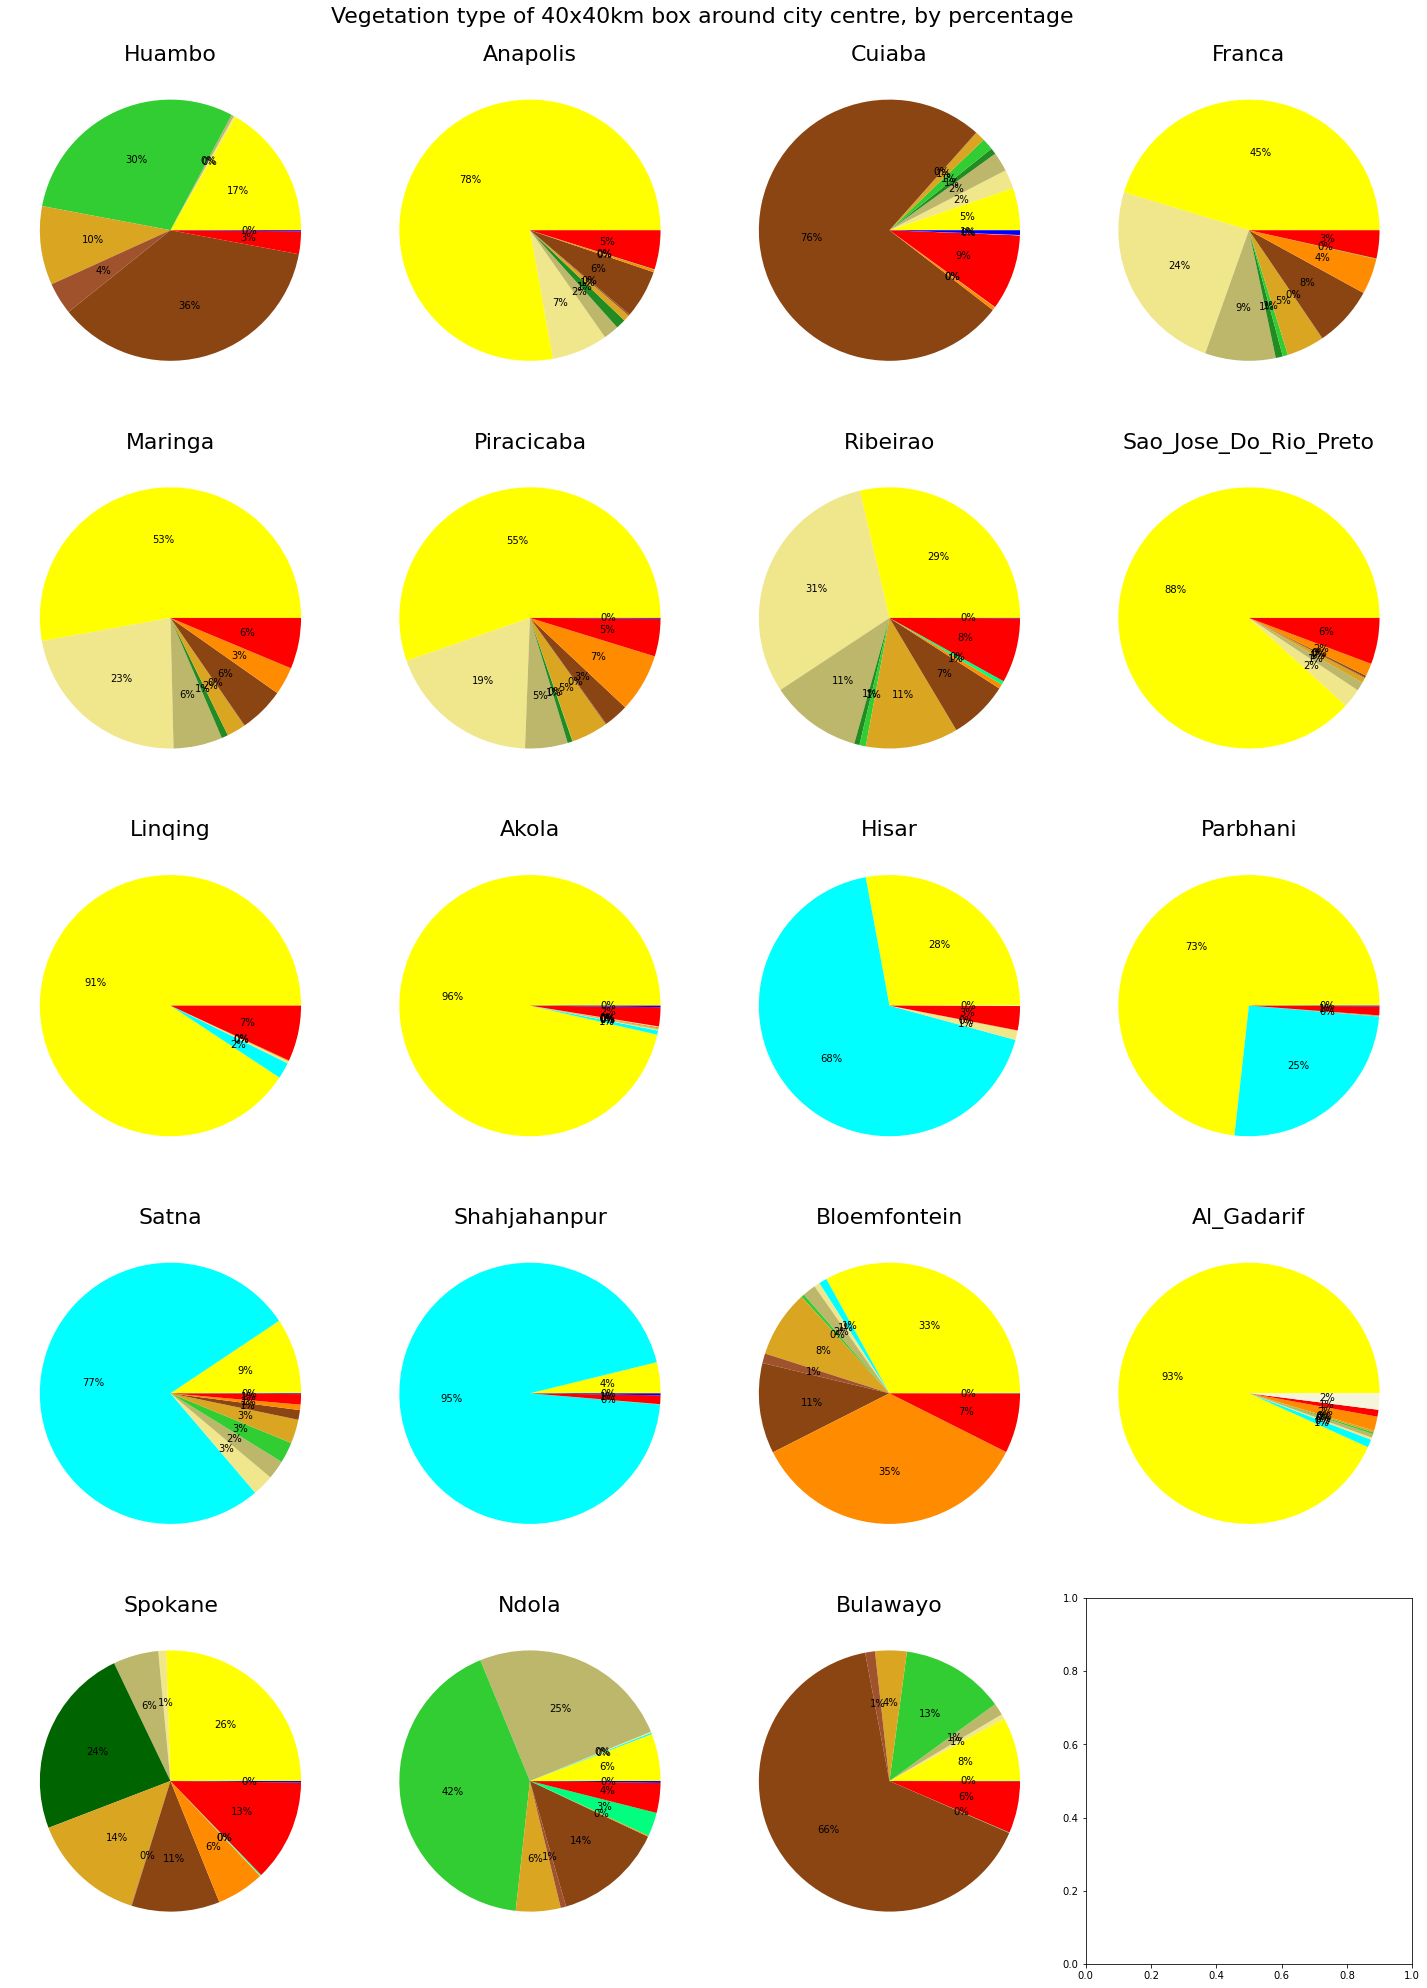

In [14]:
#Loop
#run through all the cities and plot a pie chart of the land cover types
#set path to where the files are
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))

#create the axes the add the plots to 
fig, axes = plt.subplots(5,4, figsize = (20, 28))
fig.tight_layout(pad=0.2)
fig.suptitle("Vegetation type of 40x40km box around city centre, by percentage", fontsize = 22)
plt.subplots_adjust(top=0.96)

#loop through cities and plot on the axes
for i in range(len(CITY_COUNTRY_lat_lon)):
    CITY_COUNTRY = CITY_COUNTRY_lat_lon['CITY_COUNTRY'][i] 
    city_name = CITY_COUNTRY_lat_lon['City'][i]   
    
    #read in the LULC pickle
    with open('UHI_Project_Pickle_Files\LULC_Pickles\LULC_{}.pkl'.format(CITY_COUNTRY), 'rb') as f:
        LULC_df = pickle.load(f)
    
    #create the percentages dataframe for the year 2015
    #create a dataframe to be filled
    LULC_percentages = LULC_key.copy()
    LULC_percentages['Percent_2015'] = 0

    total = LULC_df.count()[0] # total number of pixels

    #take global definitions, so if regional (ie 11, 12, etc), round down
    LULC_df['lccs_class_overall_2015'] = LULC_df['lccs_class_overall_2015'].round(-1)

    #work out the percentages for 2015
    lccs_count_2015 = pd.DataFrame(data = 100* LULC_df.groupby(['lccs_class_overall_2015']).Latitude.count()/total )
    lccs_count_2015.columns = ['percent'] 
    lccs_count_2015['Value'] = lccs_count_2015.index

    #add to the percentages dataframe
    for x in range(len(lccs_count_2015)):
        value = lccs_count_2015.iloc[x].Value
        percent = lccs_count_2015.iloc[x].percent
        LULC_percentages.loc[LULC_percentages['Value'] == value, 'Percent_2015'] = percent
    
    #create the reference for the plot (4 columns)
    plotrow = int((i - (i%4))/4)
    plotcol = i%4       
 
    per_2015 = LULC_percentages[(LULC_percentages['Percent_2015'] != 0)].Percent_2015
    labels = LULC_percentages[(LULC_percentages['Percent_2015'] != 0)].Label
    label_color = LULC_percentages[(LULC_percentages['Percent_2015'] != 0)].Label_color
    
    axes[plotrow, plotcol].pie(per_2015, labels = labels, labeldistance = None, colors = label_color, autopct='%1.0f%%')
                              #, pctdistance=1.1) use this command to put %'s at end of slices
    axes[plotrow, plotcol].set_title(city_name, fontsize = 22)
    
#axes[4,3].pie(np.zeros(len(LULC_percentages)), labels = LULC_percentages.Label, labeldistance = None, 
#              colors = LULC_percentages.Label_color)
#axes[4,3].legend()
##save plot
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'Graphs_outputs'
                      , 'Landcover_plots'))
plt.savefig('landcover_percent_pies.png')

C:\Anaconda3\envs\project_environment\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  This is separate from the ipykernel package so we can avoid doing imports until


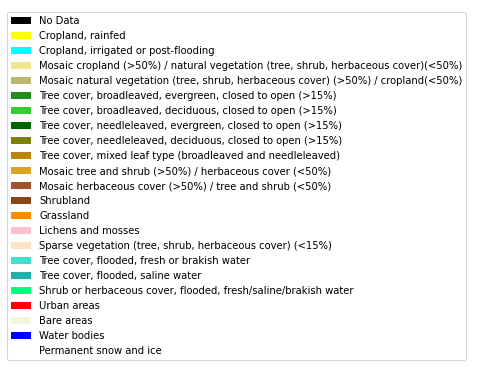

In [15]:
#get the legend
plt.pie(np.zeros(len(LULC_percentages)), labels = LULC_percentages.Label, labeldistance = None, 
              colors = LULC_percentages.Label_color)
plt.legend()
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'Graphs_outputs'
                      , 'Landcover_plots'))
plt.savefig('landcover_percent_pies_legend.png')

C:\Anaconda3\envs\project_environment\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
C:\Anaconda3\envs\project_environment\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
C:\Anaconda3\envs\project_environment\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making 

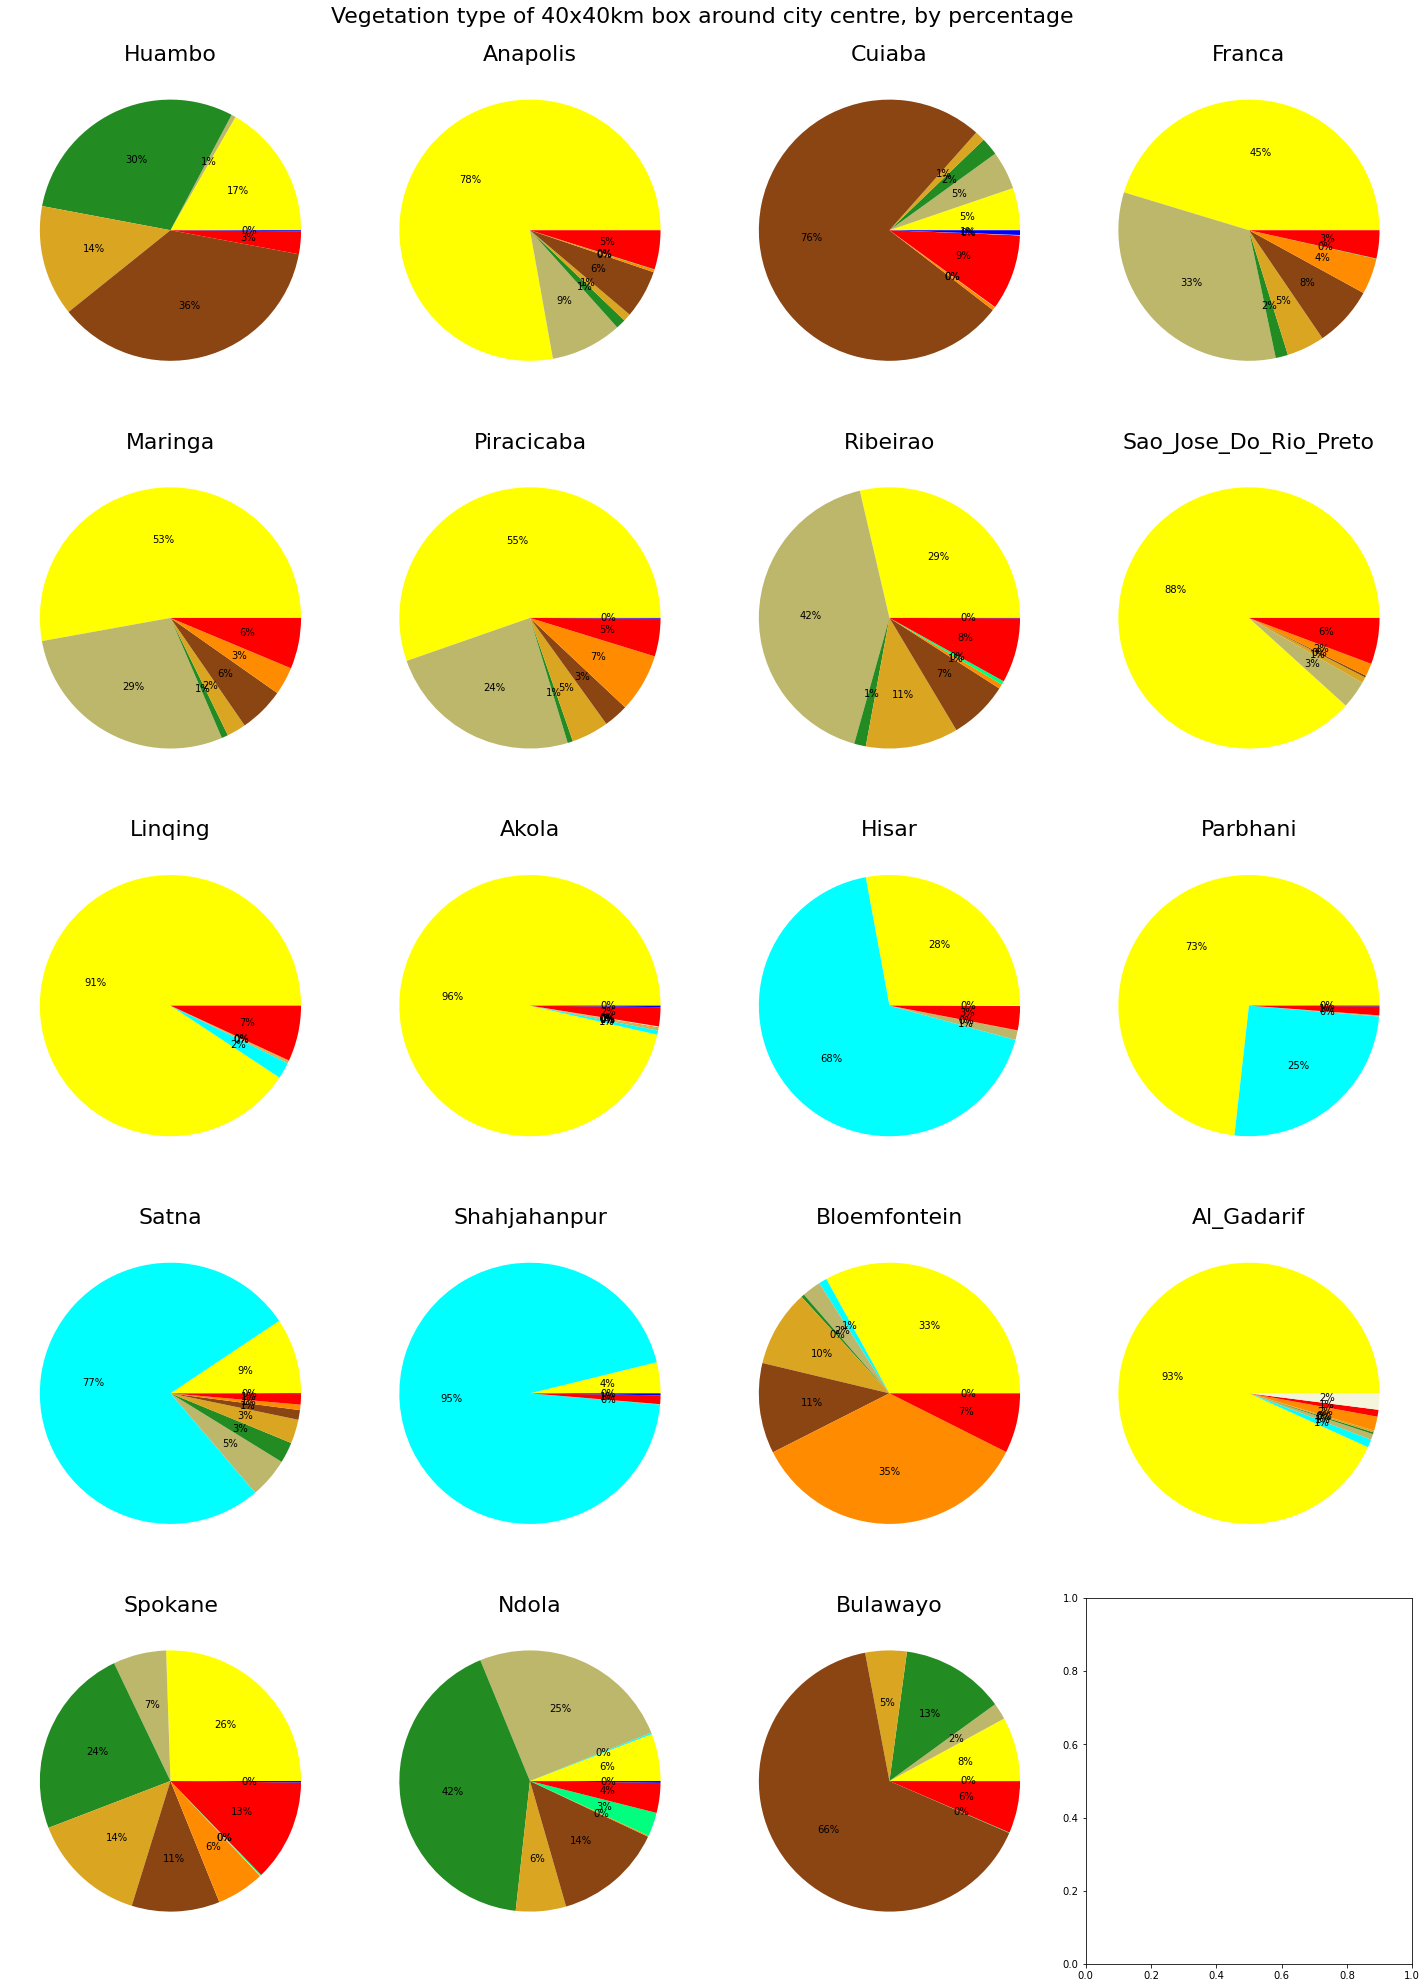

In [18]:
#Pie chart for merged categories

#Loop
#run through all the cities and plot a pie chart of the land cover types
#set path to where the files are
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))

#create the axes the add the plots to 
fig, axes = plt.subplots(5,4, figsize = (20, 28))
fig.tight_layout(pad=0.2)
fig.suptitle("Vegetation type of 40x40km box around city centre, by percentage", fontsize = 22)
plt.subplots_adjust(top=0.96)

#loop through cities and plot on the axes
for i in range(len(CITY_COUNTRY_lat_lon)):
    CITY_COUNTRY = CITY_COUNTRY_lat_lon['CITY_COUNTRY'][i] 
    city_name = CITY_COUNTRY_lat_lon['City'][i]   
    
    #read in the LULC pickle
    with open('UHI_Project_Pickle_Files\LULC_Pickles\LULC_{}.pkl'.format(CITY_COUNTRY), 'rb') as f:
        LULC_df = pickle.load(f)
    
    #create the percentages dataframe for the year 2015
    #create a dataframe to be filled
    LULC_percentages = LULC_key2.drop(columns=['Value']).drop_duplicates().copy()
    LULC_percentages['Percent_2015'] = 0

    total = LULC_df.count()[0] # total number of pixels

    #take global definitions, so if regional (ie 11, 12, etc), round down
    LULC_df['lccs_class_overall_2015'] = LULC_df['lccs_class_overall_2015'].round(-1)
    
    #add in the label for 2015    
    lccs_class_2015_label_list = []

    for n in range(len(LULC_df)):
        row = LULC_df.iloc[n]
        for x in range(len(LULC_key2)):
            if LULC_key2.iloc[x].Value == row['lccs_class_overall_2015']:
                lab = LULC_key2.iloc[x].Label2
            
        lccs_class_2015_label_list.append(lab)
    
    LULC_df['lccs_class_2015_label2'] = lccs_class_2015_label_list
    
    #work out the percentages for 2015
    lccs_count_2015 = pd.DataFrame(data = 100* LULC_df.groupby(['lccs_class_2015_label2']).Latitude.count()/total )
    lccs_count_2015.columns = ['percent']
    lccs_count_2015['Label2'] = lccs_count_2015.index

    #add to the percentages dataframe
    for a in range(len(lccs_count_2015)):
        label = lccs_count_2015.iloc[a].Label2
        percent = lccs_count_2015.iloc[a].percent
        LULC_percentages.loc[LULC_percentages['Label2'] == label, 'Percent_2015'] = percent
    
    #create the reference for the plot (4 columns)
    plotrow = int((i - (i%4))/4)
    plotcol = i%4       
 
    per_2015 = LULC_percentages[(LULC_percentages['Percent_2015'] != 0)].Percent_2015
    labels = LULC_percentages[(LULC_percentages['Percent_2015'] != 0)].Label2
    label_color = LULC_percentages[(LULC_percentages['Percent_2015'] != 0)].Label_color2
    
    axes[plotrow, plotcol].pie(per_2015, labels = labels, labeldistance = None, colors = label_color, autopct='%1.0f%%')
                              #, pctdistance=1.1) use this command to put %'s at end of slices
    axes[plotrow, plotcol].set_title(city_name, fontsize = 22)
    
#axes[4,3].pie(np.zeros(len(LULC_percentages)), labels = LULC_percentages.Label, labeldistance = None, 
#              colors = LULC_percentages.Label_color)
#axes[4,3].legend()
##save plot
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'Graphs_outputs'
                      , 'Landcover_plots'))
plt.savefig('landcover_percent_pies_label2.png')

C:\Anaconda3\envs\project_environment\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  This is separate from the ipykernel package so we can avoid doing imports until


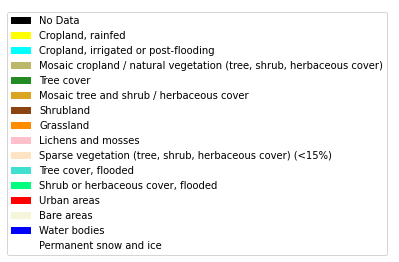

In [17]:
#get the legend
plt.pie(np.zeros(len(LULC_percentages)), labels = LULC_percentages.Label2, labeldistance = None, 
              colors = LULC_percentages.Label_color2)
plt.legend()
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'Graphs_outputs'
                      , 'Landcover_plots'))
plt.savefig('landcover_percent_pies_legend_2.png')

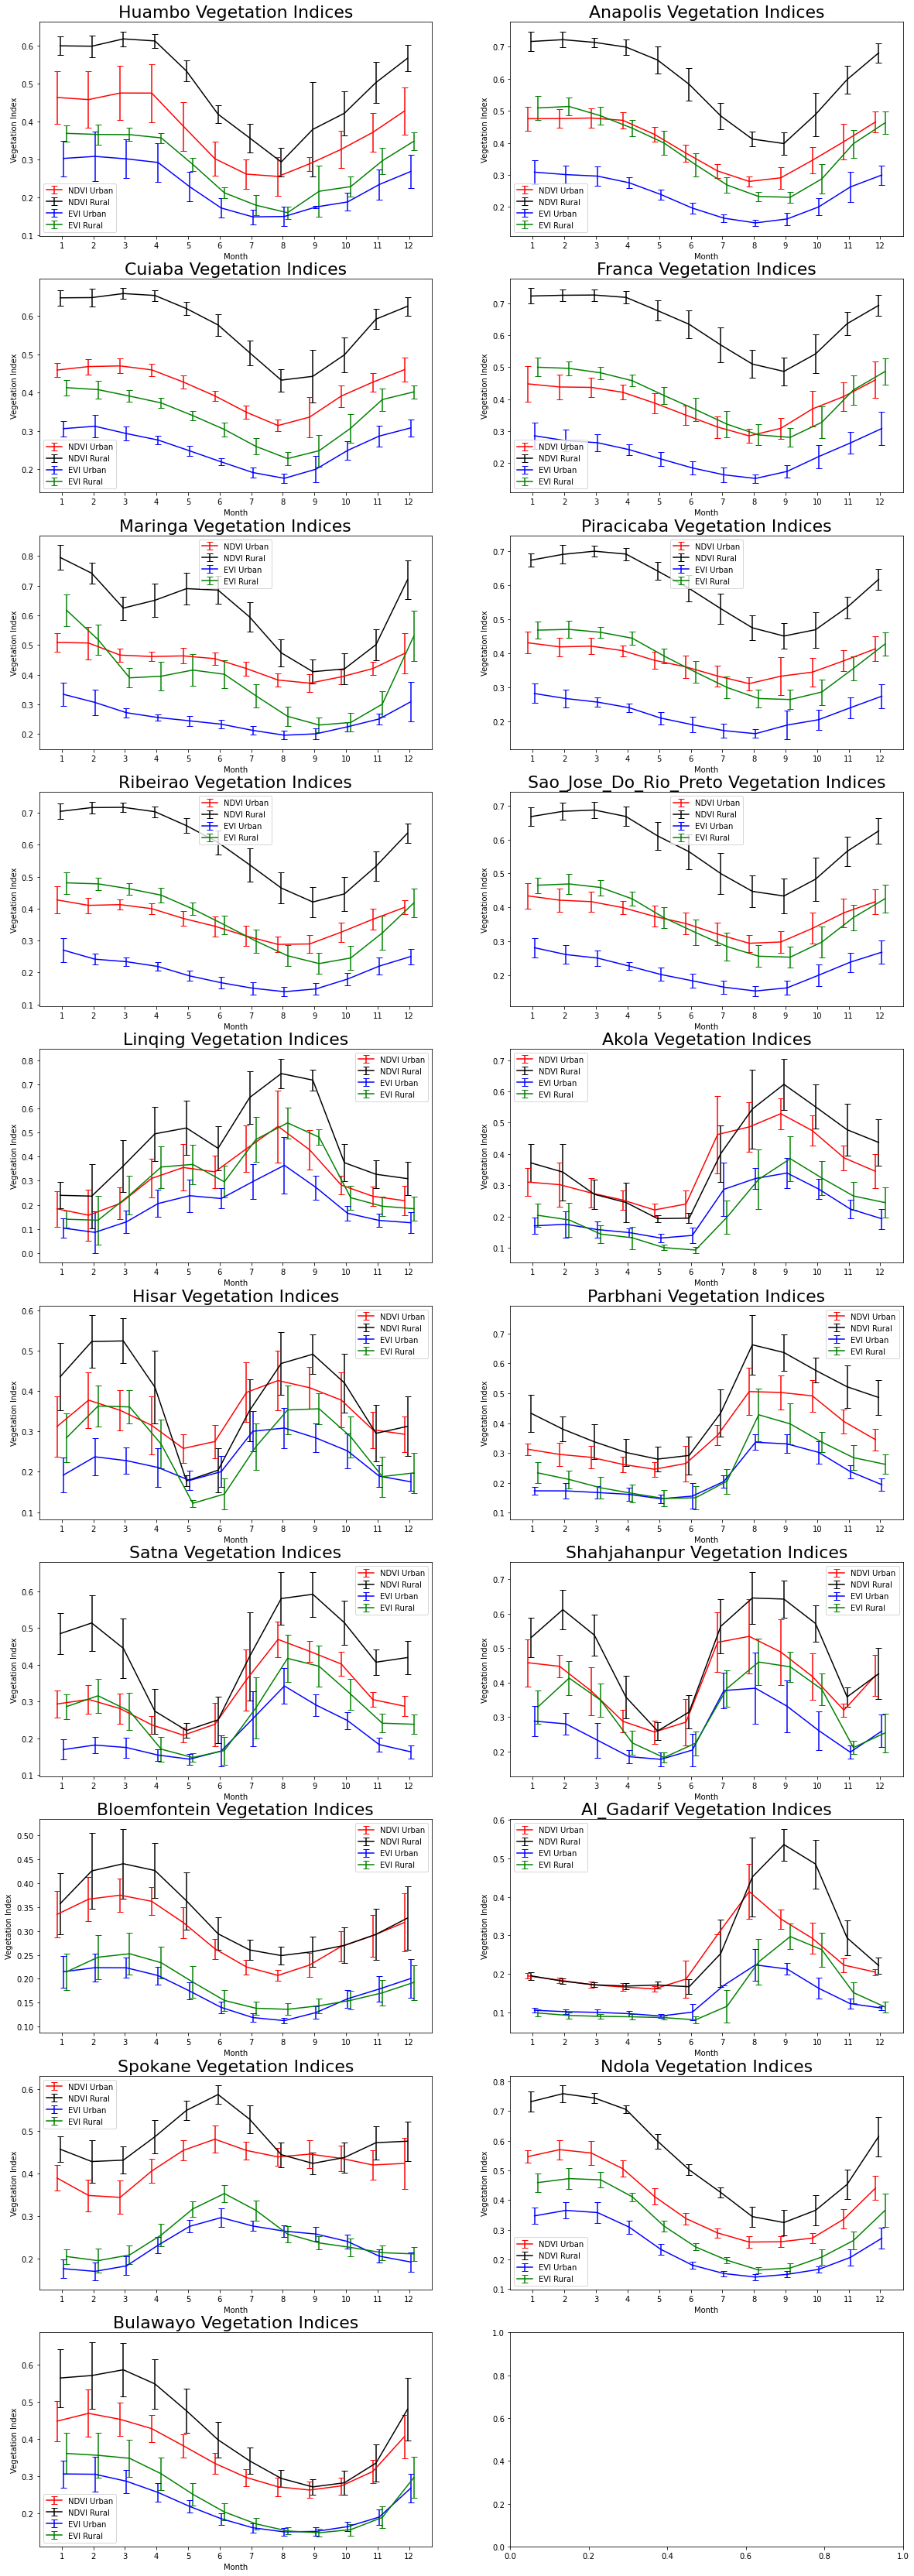

In [4]:
#read in the vegetation indices and create plots of the mean NDVI and EVI for urban versus rural areas

#create the empty plots
fig, axes = plt.subplots(10,2, figsize = (20, 60))
mons = ['1','2','3','4','5','6','7','8','9','10','11','12']

#fill the plots 

for i in range(len(CITY_COUNTRY_lat_lon)):
    CITY_COUNTRY = CITY_COUNTRY_lat_lon['CITY_COUNTRY'][i] 
    city_name = CITY_COUNTRY_lat_lon['City'][i]  
    #read in parameters table - only need one as all the others will be the same (same ndvi and evi)
    SATELLITE = 'MOD11A2' #TERRA
    os.chdir(os.path.join('D:\\','MODIS_8_day_LST', CITY_COUNTRY, SATELLITE))

    pickle_name = 'Parameters_Day_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'rb') as f:
        terra_parameters_day = pickle.load(f)
    
    #calculate monthly average VIs 

    terra_parameters_day_avgs = terra_parameters_day.groupby(['Month']).aggregate({"ndvi_urban_mean":np.mean, 
                                                                                   "ndvi_rural_mean":np.mean,
                                                                                   "evi_urban_mean":np.mean,
                                                                                   "evi_rural_mean":np.mean})

    terra_parameters_day_stds = terra_parameters_day.groupby(['Month']).aggregate({"ndvi_urban_mean":np.std,
                                                                                   "ndvi_rural_mean":np.std,
                                                                                   "evi_urban_mean":np.std,
                                                                                   "evi_rural_mean":np.std})

    #create the reference for the plot (2 columns)
    plotrow = int((i - (i%2))/2)
    plotcol = i%2    
    
    #transformations to offset error bars
    trans1 = Affine2D().translate(-0.15, 0.0) + axes[plotrow, plotcol].transData
    trans2 = Affine2D().translate(-0.05, 0.0) + axes[plotrow, plotcol].transData 
    trans3 = Affine2D().translate(+0.05, 0.0) + axes[plotrow, plotcol].transData
    trans4 = Affine2D().translate(+0.15, 0.0) + axes[plotrow, plotcol].transData
    
    p1 = axes[plotrow, plotcol].errorbar(mons, terra_parameters_day_avgs.ndvi_urban_mean, 
                                   yerr = terra_parameters_day_stds.ndvi_urban_mean, color = 'red', label = 'NDVI Urban'
                                  ,transform = trans1, capsize = 4)  #create plot 
    p2 = axes[plotrow, plotcol].errorbar(mons, terra_parameters_day_avgs.ndvi_rural_mean, 
                                   yerr = terra_parameters_day_stds.ndvi_rural_mean,color = 'black', label = 'NDVI Rural'
                                  ,transform = trans2, capsize = 4)
    p3 = axes[plotrow, plotcol].errorbar(mons, terra_parameters_day_avgs.evi_urban_mean,
                                   yerr = terra_parameters_day_stds.evi_urban_mean, color = 'blue', label = 'EVI Urban'
                                  ,transform = trans3, capsize = 4)
    p4 = axes[plotrow, plotcol].errorbar(mons, terra_parameters_day_avgs.evi_rural_mean,
                                   yerr = terra_parameters_day_stds.evi_rural_mean, color = 'green', label = 'EVI Rural'
                                  ,transform = trans4, capsize = 4)   

    axes[plotrow, plotcol].set_title('{} Vegetation Indices'.format(city_name), fontsize = 22)
    axes[plotrow, plotcol].set(ylabel = 'Vegetation Index', xlabel = 'Month')
    axes[plotrow, plotcol].legend()
    

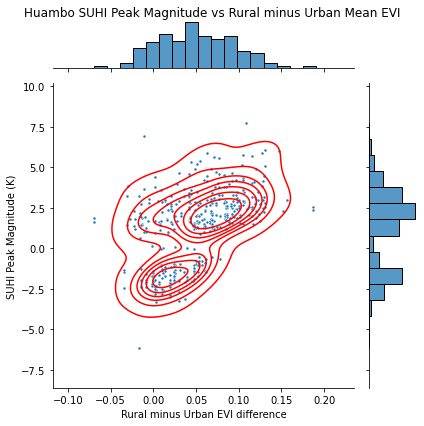

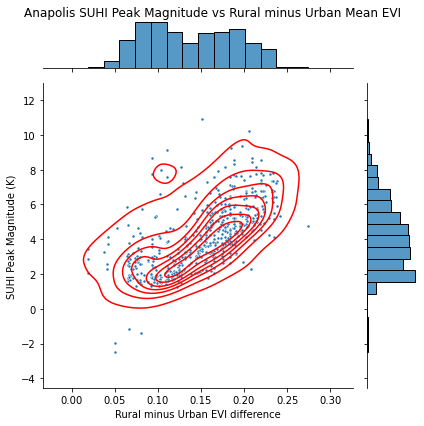

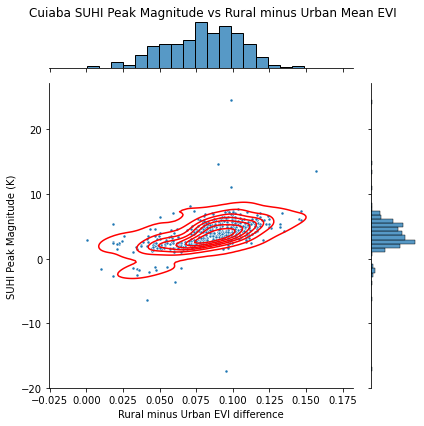

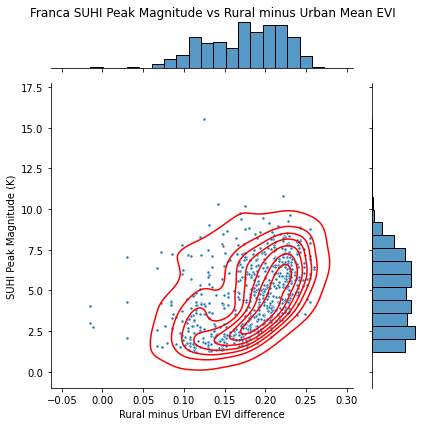

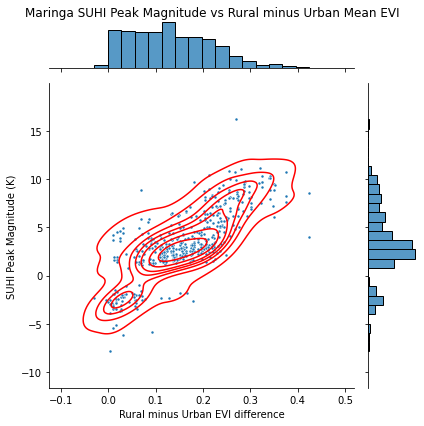

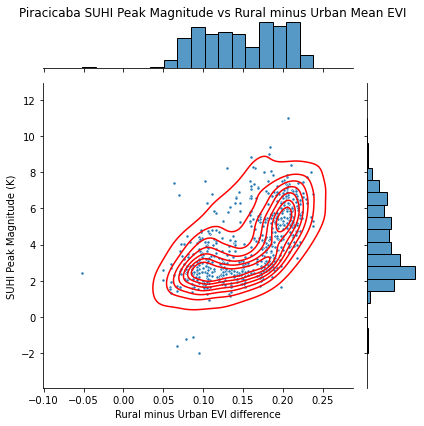

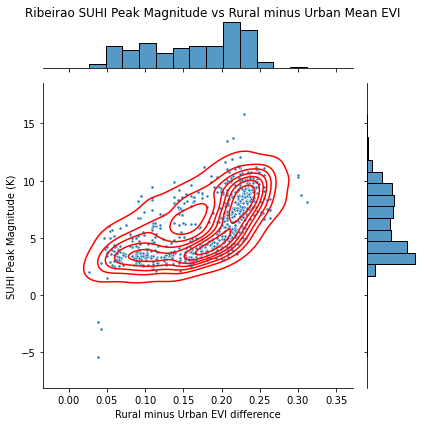

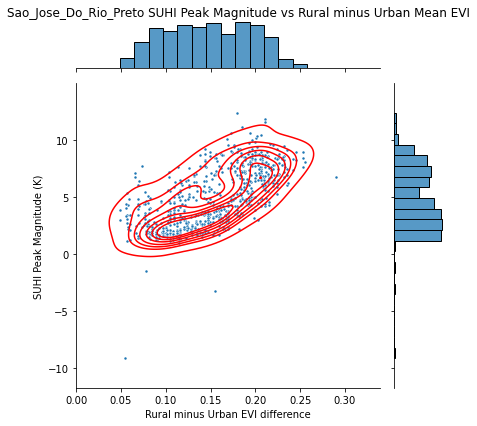

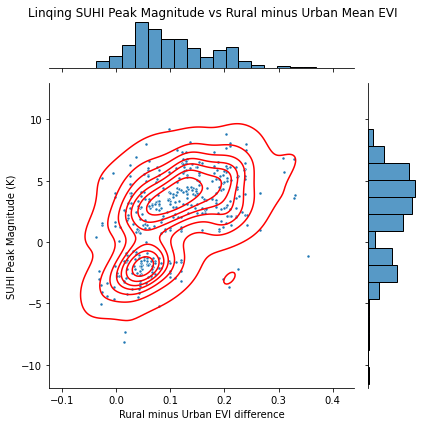

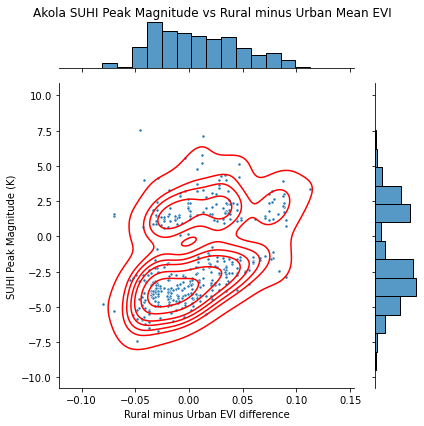

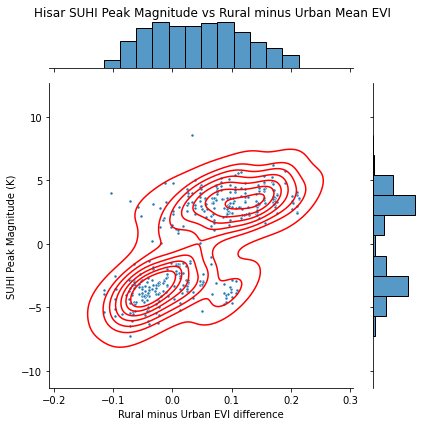

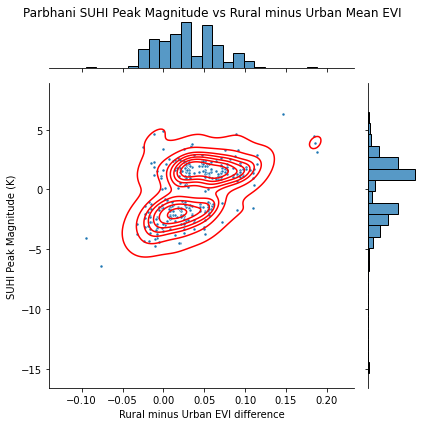

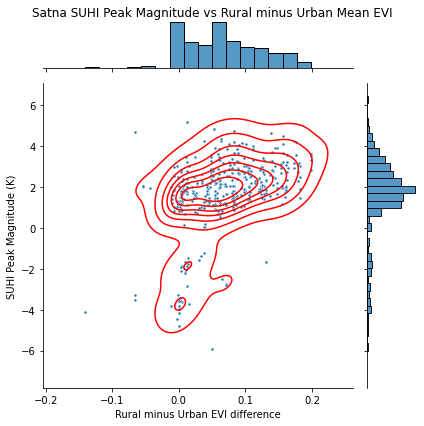

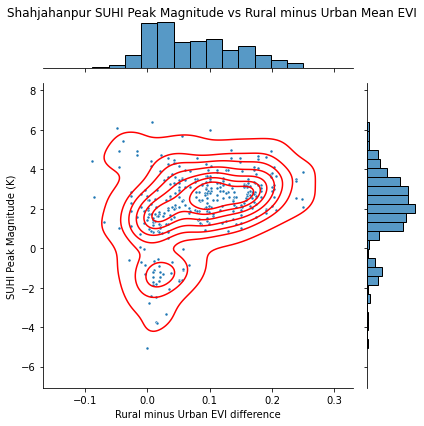

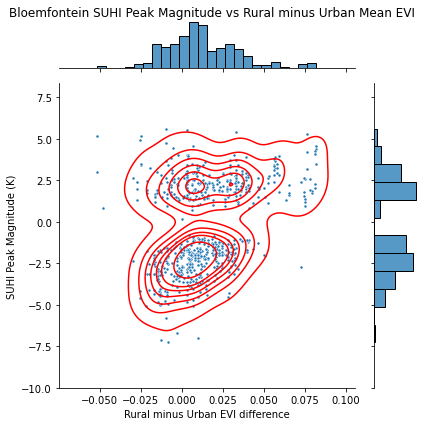

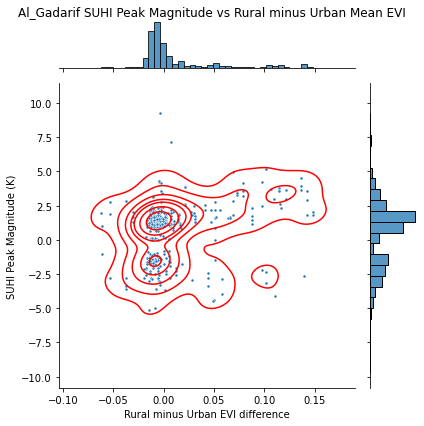

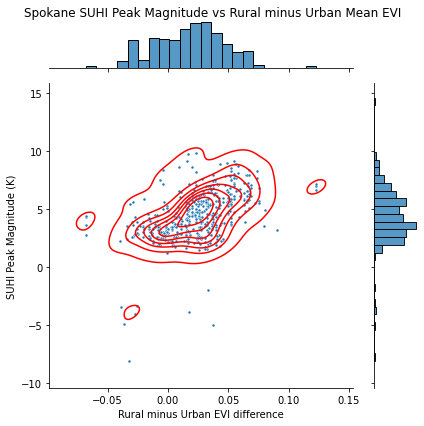

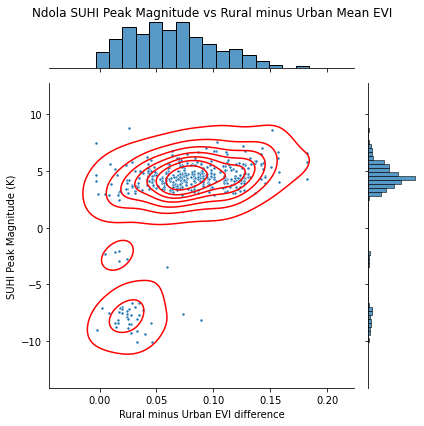

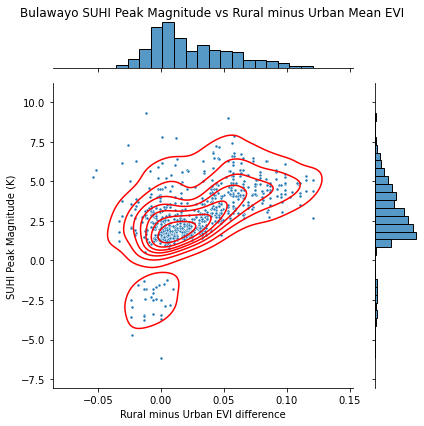

In [183]:
#scatter density plot with contours of EVI vs SUHI mag (a0)
#a0
#seaborn contour plot 
#have to plot all separately as joint plot doesn't allow for separate axes easily

#loop through all overpasses and save the plot
for i in range(len(CITY_COUNTRY_lat_lon)):
    CITY_COUNTRY = CITY_COUNTRY_lat_lon['CITY_COUNTRY'][i] 
    city_name = CITY_COUNTRY_lat_lon['City'][i]  
    #read in parameters table 
    SATELLITE = 'MOD11A2' #
    os.chdir(os.path.join('D:\\','MODIS_8_day_LST', CITY_COUNTRY, SATELLITE))

    pickle_name = 'Parameters_Day_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'rb') as f:
        terra_parameters_day = pickle.load(f)
        
    x = terra_parameters_day.evi_rural_mean - terra_parameters_day.evi_urban_mean
    y = terra_parameters_day.day_a0

    a = (sns.jointplot(x = x, y = y, marker='.').plot_joint(sns.kdeplot, n_levels=8, color ='Red'))
    a.set_axis_labels('Rural minus Urban EVI difference', 'SUHI Peak Magnitude (K)')
    a.fig.suptitle('{} SUHI Peak Magnitude vs Rural minus Urban Mean EVI'.format(city_name))
    a.fig.tight_layout()
    a.fig.subplots_adjust(top=0.95) # Reduce plot to make room
    #save the plot
    #os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','Graphs_outputs', 'Seaborn_contour_plots'
    #                 ,'all_cities'))   
    #plt.savefig('RH_a0_{}_overpass.png'.format(file_overpass_name_list[i]))


In [175]:
terra_parameters_day

,Filename,Date,Year,Month,day_a0,day_x0,day_y0,day_phi,day_ax,day_ay,...,ndvi_reg_slope_rural_lst,ndvi_reg_slope_all_lst,evi_reg_slope_urban_lst,evi_reg_slope_urban_suhi,evi_reg_slope_rural_lst,evi_reg_slope_all_lst,ndvi_urban_mean,ndvi_rural_mean,evi_urban_mean,evi_rural_mean
0,MOD11A2.A2000057.h20v11.006.2015057173450.hdf,26/02/2000,2000.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.012460,-0.018694,-0.013674,-0.015636,-0.006294,-0.009267,0.460321,0.659426,0.277887,0.367552
1,MOD11A2.A2000065.h20v11.006.2015057173928.hdf,05/03/2000,2000.0,3.0,4.019952,-3.020729,0.366068,-131.385262,7.464972,11.287142,...,-0.028369,-0.028818,0.010643,0.016778,-0.012539,-0.012768,0.460200,0.624777,0.313350,0.393490
2,MOD11A2.A2000081.h20v11.006.2015057191358.hdf,21/03/2000,2000.0,3.0,3.633111,-6.043998,0.411856,-122.644359,5.266062,9.946003,...,-0.029450,-0.030305,0.039211,0.066259,-0.017500,-0.017880,0.460200,0.624554,0.313350,0.393444
3,MOD11A2.A2000089.h20v11.006.2015058064320.hdf,29/03/2000,2000.0,3.0,4.389550,-3.536444,-0.428373,178.317787,13.025464,7.791660,...,-0.046157,-0.046758,0.057308,0.114004,-0.023656,-0.023917,0.460200,0.624777,0.313350,0.393490
4,MOD11A2.A2000097.h20v11.006.2015058233638.hdf,06/04/2000,2000.0,4.0,3.965572,-3.916483,0.242989,166.236403,9.958981,7.756868,...,-0.050742,-0.053956,-0.043399,-0.046835,-0.021371,-0.024008,0.456673,0.630662,0.271435,0.358285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903,MOD11A2.A2020329.h20v11.006.2020338105459.hdf,24/11/2020,2020.0,11.0,2.537590,-9.000000,1.330347,158.859391,14.544574,5.494308,...,-0.013175,-0.013260,-0.016289,-0.014342,-0.008851,-0.008874,0.372444,0.376288,0.207889,0.213627
904,MOD11A2.A2020345.h20v11.006.2020358214939.hdf,10/12/2020,2020.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.023490,-0.025663,-0.011872,-0.011304,-0.018470,-0.017963,0.479845,0.583419,0.331430,0.379836
905,MOD11A2.A2020353.h20v11.006.2020364220808.hdf,18/12/2020,2020.0,12.0,4.039360,-3.907019,0.674367,146.380473,10.868890,5.789896,...,-0.018275,-0.023495,-0.012280,-0.012508,-0.016455,-0.017076,0.479845,0.583442,0.331430,0.379844
906,MOD11A2.A2020361.h20v11.006.2021004033159.hdf,26/12/2020,2020.0,12.0,6.371810,-3.989546,1.359780,-22.225972,11.954266,5.620810,...,-0.012219,-0.014111,-0.007874,-0.008338,-0.008263,-0.008881,0.481524,0.585681,0.335787,0.382312


In [181]:
#calculate monthly average regression slops
#ndvi
terra_parameters_day_avgs = terra_parameters_day.groupby(['Month']).aggregate({"ndvi_reg_slope_all_lst":np.mean, 
                                                                               "ndvi_reg_slope_urban_lst":np.mean, 
                                                                             "ndvi_reg_slope_rural_lst":np.mean,
                                                                              "ndvi_reg_slope_urban_suhi":np.mean})
                                                                               

terra_parameters_day_stds = terra_parameters_day.groupby(['Month']).aggregate({"ndvi_reg_slope_all_lst":np.std, 
                                                                               "ndvi_reg_slope_urban_lst":np.std, 
                                                                             "ndvi_reg_slope_rural_lst":np.std,
                                                                              "ndvi_reg_slope_urban_suhi":np.std})

terra_parameters_day_avgs

,ndvi_reg_slope_all_lst,ndvi_reg_slope_urban_lst,ndvi_reg_slope_rural_lst,ndvi_reg_slope_urban_suhi
Month,,,,
1.0,-0.000218,-0.000527,-0.000257,0.000304
2.0,0.001420,-0.000176,0.001408,-0.000048
3.0,-0.000106,-0.001025,-0.000086,-0.000063
4.0,-0.000293,-0.005348,-0.000314,-0.004702
5.0,0.000111,-0.000062,0.000099,-0.000181
6.0,0.000405,0.000091,0.000408,-0.001455
7.0,-0.000040,-0.001530,-0.000034,0.001735
8.0,0.004179,0.000840,0.003297,0.000810
9.0,-0.000508,0.001760,-0.000510,0.001887


In [182]:
#evi
terra_parameters_day_avgs = terra_parameters_day.groupby(['Month']).aggregate({"evi_reg_slope_all_lst":np.mean, 
                                                                               "evi_reg_slope_urban_lst":np.mean, 
                                                                             "evi_reg_slope_rural_lst":np.mean,
                                                                              "evi_reg_slope_urban_suhi":np.mean})
                                                                               

terra_parameters_day_stds = terra_parameters_day.groupby(['Month']).aggregate({"evi_reg_slope_all_lst":np.std, 
                                                                               "evi_reg_slope_urban_lst":np.std, 
                                                                             "evi_reg_slope_rural_lst":np.std,
                                                                              "evi_reg_slope_urban_suhi":np.std})

terra_parameters_day_avgs

,evi_reg_slope_all_lst,evi_reg_slope_urban_lst,evi_reg_slope_rural_lst,evi_reg_slope_urban_suhi
Month,,,,
1.0,-0.012466,-0.017389,-0.012267,-0.017396
2.0,-0.010093,-0.012953,-0.009823,-0.012628
3.0,-0.007045,-0.020764,-0.006680,-0.018967
4.0,-0.008515,-0.025890,-0.008056,-0.023240
5.0,-0.017342,-0.024096,-0.016891,-0.023717
6.0,-0.020993,-0.018412,-0.021047,-0.017161
7.0,-0.015919,-0.003203,-0.016280,0.002681
8.0,-0.002574,0.004565,-0.004584,0.004455
9.0,-0.014010,-0.001943,-0.014058,-0.001518


In [183]:
#correlation
#ndvi
terra_parameters_day_avgs = terra_parameters_day.groupby(['Month']).aggregate({"ndvi_corr_all_lst":np.mean, 
                                                                               "ndvi_corr_urban_lst":np.mean, 
                                                                             "ndvi_corr_rural_lst":np.mean,
                                                                              "ndvi_corr_urban_suhi":np.mean})
                                                                               

terra_parameters_day_stds = terra_parameters_day.groupby(['Month']).aggregate({"ndvi_corr_all_lst":np.std, 
                                                                               "ndvi_corr_urban_lst":np.std, 
                                                                             "ndvi_corr_rural_lst":np.std,
                                                                              "ndvi_corr_urban_suhi":np.std})

terra_parameters_day_avgs

,ndvi_corr_all_lst,ndvi_corr_urban_lst,ndvi_corr_rural_lst,ndvi_corr_urban_suhi
Month,,,,
1.0,-0.001167,-0.031069,-0.005237,-0.017449
2.0,0.109427,-0.007468,0.110874,-0.073291
3.0,-0.028574,-0.060377,-0.023651,-0.064207
4.0,-0.016104,-0.059198,-0.017456,-0.084682
5.0,0.131060,0.063361,0.146754,0.029730
6.0,0.285591,0.223214,0.296476,0.101502
7.0,0.140724,0.197732,0.147323,0.184734
8.0,0.143435,0.478427,0.152287,0.459440
9.0,0.122537,0.372540,0.121892,0.313983


In [184]:
#correlation
#evi
terra_parameters_day_avgs = terra_parameters_day.groupby(['Month']).aggregate({"evi_corr_all_lst":np.mean, 
                                                                               "evi_corr_urban_lst":np.mean, 
                                                                             "evi_corr_rural_lst":np.mean,
                                                                              "evi_corr_urban_suhi":np.mean})
                                                                               

terra_parameters_day_stds = terra_parameters_day.groupby(['Month']).aggregate({"evi_corr_all_lst":np.std, 
                                                                               "evi_corr_urban_lst":np.std, 
                                                                             "evi_corr_rural_lst":np.std,
                                                                              "evi_corr_urban_suhi":np.std})

terra_parameters_day_avgs

,evi_corr_all_lst,evi_corr_urban_lst,evi_corr_rural_lst,evi_corr_urban_suhi
Month,,,,
1.0,-0.438349,-0.317740,-0.434974,-0.284235
2.0,-0.401836,-0.321062,-0.398839,-0.300574
3.0,-0.280936,-0.443245,-0.273524,-0.414440
4.0,-0.277612,-0.309818,-0.268888,-0.293387
5.0,-0.599101,-0.375044,-0.602109,-0.337217
6.0,-0.755340,-0.226747,-0.765992,-0.159744
7.0,-0.630375,0.036983,-0.646258,0.071489
8.0,-0.178509,0.132714,-0.241369,0.133074
9.0,-0.515177,-0.150711,-0.516721,-0.120261


In [190]:
#create a table of the correlations for each city

#make empty table to be filled



for i in range(len(CITY_COUNTRY_lat_lon)):
    CITY_COUNTRY = CITY_COUNTRY_lat_lon['CITY_COUNTRY'][i] 
    city_name = CITY_COUNTRY_lat_lon['City'][i]  
    #read in parameters table - only need one as all the others will be the same (same ndvi and evi)
    SATELLITE = 'MOD11A2' #TERRA
    os.chdir(os.path.join('D:\\','MODIS_8_day_LST', CITY_COUNTRY, SATELLITE))

    pickle_name = 'Parameters_Day_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'rb') as f:
        terra_parameters_day = pickle.load(f)
    
    #calculate monthly average VIs 
    #ndvi
    terra_parameters_day_avgs = terra_parameters_day.groupby(['Month']).aggregate({"ndvi_corr_all_lst":np.mean, 
                                                                               "ndvi_corr_urban_lst":np.mean, 
                                                                             "ndvi_corr_rural_lst":np.mean,
                                                                              "ndvi_corr_urban_suhi":np.mean})
                                                                               

    terra_parameters_day_stds = terra_parameters_day.groupby(['Month']).aggregate({"ndvi_corr_all_lst":np.std, 
                                                                               "ndvi_corr_urban_lst":np.std, 
                                                                             "ndvi_corr_rural_lst":np.std,
                                                                              "ndvi_corr_urban_suhi":np.std})

    #evi
    terra_parameters_day_avgs = terra_parameters_day.groupby(['Month']).aggregate({"evi_corr_all_lst":np.mean, 
                                                                               "evi_corr_urban_lst":np.mean, 
                                                                             "evi_corr_rural_lst":np.mean,
                                                                              "evi_corr_urban_suhi":np.mean})
                                                                               

    terra_parameters_day_stds = terra_parameters_day.groupby(['Month']).aggregate({"evi_corr_all_lst":np.std, 
                                                                               "evi_corr_urban_lst":np.std, 
                                                                             "evi_corr_rural_lst":np.std,
                                                                              "evi_corr_urban_suhi":np.std})

    
    

4 1


In [163]:
#calculate the city vs rural elevation differences
#read in elevation data
elevation = xr.open_dataset(r'\Users\muj19qhu\Documents\Python_Scripts\PROJECT\Elevation\data.nc')
topo = elevation['topo']

CITY_COUNTRY_lat_lon['mean_elevation_rural'] = np.nan
CITY_COUNTRY_lat_lon['mean_elevation_city'] = np.nan
CITY_COUNTRY_lat_lon['std_elevation_rural'] = np.nan
CITY_COUNTRY_lat_lon['std_elevation_city'] = np.nan

for ia in range(len(CITY_COUNTRY_lat_lon)):
    
    CITY_COUNTRY = CITY_COUNTRY_lat_lon.CITY_COUNTRY[ia]
    City_Lat = CITY_COUNTRY_lat_lon.Lat[ia]
    City_Lon = CITY_COUNTRY_lat_lon.Lon[ia]
    min_lon = (CITY_COUNTRY_lat_lon.Lon - 0.2).values[ia]
    max_lon = (CITY_COUNTRY_lat_lon.Lon + 0.2).values[ia]
    min_lat = (CITY_COUNTRY_lat_lon.Lat - 0.2).values[ia]
    max_lat = (CITY_COUNTRY_lat_lon.Lat + 0.2).values[ia]
    local_epsg = CITY_COUNTRY_lat_lon.Local_epsg[ia]

    #Load in LULC data, these bases were created in JASMIN
    with open('UHI_Project_Pickle_Files\LULC_Pickles\LULC_{}.pkl'.format(CITY_COUNTRY), 'rb') as f:
         LULC_df = pickle.load(f)

    # topo X is longitude, Y is latitude 
    topo2 = topo.sel(X = slice(min_lon, max_lon), Y = slice(max_lat, min_lat))
    topo2_df = topo2.to_dataframe()
    topo2_df = topo2_df.reset_index(level=['X', 'Y'])
    topo2_df.columns = ['Latitude', 'Longitude', 'topo']
    
    #cast geographic coordinate pair to the local projected system
    transformer = Transformer.from_crs('epsg:4326', 'epsg:{}'.format(local_epsg), always_xy=True) #WGS84 geographic, current crs to local crs
    #get the city centre x, y coordinates
    city_x, city_y = transformer.transform(City_Lon, City_Lat)

    x_points = []
    y_points = []

    for ib in range(len(topo2_df)):
        input_lon = topo2_df.Longitude[ib]
        input_lat = topo2_df.Latitude[ib]
        x, y = transformer.transform(input_lon, input_lat)
        x = x- city_x
        y = y- city_y
        x_points.append(x)
        y_points.append(y)
    
    topo2_df['x_points'] = x_points
    topo2_df['y_points'] = y_points
    
    #add in the elevation to the LULC dataframe
    LULC_df['elevation'] = np.nan
    LULC_df['ele_dist'] = np.nan
    elevation_points = [[x, y] for x, y in topo2_df[['x_points','y_points']].values]
    LULC_points =  [[x, y] for x, y in LULC_df[['x_points','y_points']].values]

    for ic in range(len(LULC_df)):   
        pt = LULC_points[ic]
        distance,index = spatial.cKDTree(elevation_points).query(pt)
        #distance # <-- The distances to the nearest neighbors
        #index # <-- The locations of the neighbors
        LULC_df.loc[ic, 'elevation'] = topo2_df.topo.iloc[index]
        #LULC_df.loc[ic, 'ele_dist'] = distance
    
    #add in mean and std elevation for the city and surronding rural area
    CITY_COUNTRY_lat_lon.loc[ia, 'mean_elevation_rural'] = LULC_df[(LULC_df['is_urban_overall_2015'] == 0)].elevation.mean()
    CITY_COUNTRY_lat_lon.loc[ia, 'mean_elevation_city'] = LULC_df[(LULC_df['is_urban_overall_2015'] == 1)].elevation.mean()
    CITY_COUNTRY_lat_lon.loc[ia, 'std_elevation_rural'] = LULC_df[(LULC_df['is_urban_overall_2015'] == 0)].elevation.std()
    CITY_COUNTRY_lat_lon.loc[ia, 'std_elevation_city'] = LULC_df[(LULC_df['is_urban_overall_2015'] == 1)].elevation.std()


C:\Anaconda3\envs\project_environment\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
C:\Anaconda3\envs\project_environment\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
C:\Anaconda3\envs\project_environment\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making 

In [165]:
#save as excel so have elevation saved to use
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))
CITY_COUNTRY_lat_lon.to_excel("CITY_COUNTRY_lat_lon.xlsx", index = False) 